# Order cnacellation prediction

This project was created to take part in Kaggle competition, that was a part of a Machine Leraning course I took. The biggest profit of this exercise was working on real world data, what is a greatly different experience then prepared machine learning exercises.

In [1]:
from collections import defaultdict, Counter
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

Using TensorFlow backend.


Data used in this project contains purchase information from an online store. Features contain things like product describrion, price, quantity and most importantly if the product was returned. The takst is to predict based on that data if other products will be also returned.

Importing data:
Data consists of two subsets: train and test. Test subset is missing target variable. For the now there were merged together.

In [2]:
train = pd.read_hdf('../../module3/input/train_online_retail.h5')
test = pd.read_hdf('../../module3/input/test_online_retail.h5')
df_all = pd.concat([train, test], sort=False)
del train, test
gc.collect()

165

Pandas options were changed so all columns will appear.

In [3]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

# Feature engineering

'customer feats', 'product feats' and 'product per customer feats' listed below are aggregations of information concerning customer or product and how often was it returned.

 - 'describtion feats' are based on keywords in description of a produkt

 - 'date feats' are parsed from date feature

 - 'categorical feats' were changed into numerical values using factorize function

In [4]:
def group_to_dict(df, group_key, agg_func):
    df = df[ ~df['is_canceled'].isnull() ]
    dict_ = df.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
    
    if type(group_key) == list:
        keys_to_del = []
        for key in dict_.keys():
            if -1 in key:
                keys_to_del.append(key)
        for key in keys_to_del:
            del dict_[key]
    else:
        if -1 in dict_: del dict_[-1]
    
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [5]:
train = df_all[ ~df_all['is_canceled'].isnull()]
description_canc = train.groupby(['stock_code', 'description'])['is_canceled'].agg(np.sum).reset_index()
description_canc['is_canceled'] = description_canc['is_canceled'].astype(int)
description_canc['description'] = description_canc['description'].map(lambda x: str(x).strip())
description_canc['words'] = description_canc['description'].map(lambda x: x.split(' '))

most_canceled_words = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]    
    for word in word_lst:
        curr_num = most_canceled_words.get(word, 0)
        
        most_canceled_words[word] = curr_num + description_canc['is_canceled'].iloc[i]

#sorted(most_canceled_words.items() ,  key=lambda x: x[1], reverse=True)

words_to_del = []
for word in most_canceled_words.keys():
    if len(word) <= 2:
        words_to_del.append(word)
for word in words_to_del:
    del most_canceled_words[word]
    
most_canceled_words = defaultdict(lambda: 0, most_canceled_words)

stock_code_word_score = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]
    stock_score = 0
    for word in word_lst:
        stock_score += most_canceled_words[word]
        
    stock_code_word_score[description_canc['stock_code'].iloc[i]] = stock_score
    
stock_code_word_score = defaultdict(lambda: 0, stock_code_word_score)

In [6]:
dict_cnt_customer_orders = group_to_dict(df_all, 'customer_id', agg_func=np.size)
dict_cnt_customer_cancel = group_to_dict(df_all, 'customer_id', agg_func=np.sum)
dict_cnt_product_orders = group_to_dict(df_all, 'stock_code', agg_func=np.size)
dict_cnt_product_cancel = group_to_dict(df_all, 'stock_code', agg_func=np.sum)
dict_cnt_customer_produckt_orders = group_to_dict(df_all, ['customer_id','stock_code'], np.size)
dict_cnt_customer_produckt_cancel = group_to_dict(df_all, ['customer_id','stock_code'], np.sum)

# customer feats
df_all['cnt_customer_orders'] = df_all['customer_id'].map(dict_cnt_customer_orders)
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(dict_cnt_customer_cancel)
df_all['prc_customer_cancel'] = df_all[['cnt_customer_orders', 'cnt_customer_cancel']].apply(lambda x: x['cnt_customer_cancel'] / x['cnt_customer_orders'] if x['cnt_customer_orders'] != 0 else 0, axis=1)

# produkt feats
df_all['cnt_product_orders'] = df_all['stock_code'].map(dict_cnt_product_orders)
df_all['cnt_product_cancel'] = df_all['stock_code'].map(dict_cnt_product_cancel)
df_all['prc_product_cancel'] = df_all[['cnt_product_orders', 'cnt_product_cancel']].apply(lambda x: x['cnt_product_cancel'] / x['cnt_product_orders'] if x['cnt_product_orders'] != 0 else 0, axis=1)

# produckt per customer feats
df_all['cnt_customer_produckt_orders'] = df_all[['customer_id','stock_code']].apply(lambda x: dict_cnt_customer_produckt_orders[(x['customer_id'], x['stock_code'])], axis=1 )
df_all['cnt_customer_produckt_cancel'] = df_all[['customer_id','stock_code']].apply(lambda x: dict_cnt_customer_produckt_cancel[(x['customer_id'], x['stock_code'])], axis=1 )
df_all['prc_customer_produckt_cancel'] = df_all[['cnt_customer_produckt_orders', 'cnt_customer_produckt_cancel']].apply(lambda x: x['cnt_customer_produckt_cancel'] / x['cnt_customer_produckt_orders'] if x['cnt_customer_produckt_orders'] != 0 else 0, axis=1)

# describtion feats
df_all['stock_word_score'] = df_all['stock_code'].map(stock_code_word_score)

# date feats
df_all['invoice_year'] = df_all['invoice_date'].dt.year
df_all['invoice_month'] = df_all['invoice_date'].dt.month
df_all['invoice_day_of_m'] = df_all['invoice_date'].dt.day
df_all['invoice_day_of_y'] = df_all['invoice_date'].dt.dayofyear
df_all['invoice_hour'] = df_all['invoice_date'].dt.hour

# categorical feats
df_all['country__cat'] = pd.factorize(df_all['country'])[0]

In [7]:
df_all.dtypes

invoice                                  int32
stock_code                               int16
description                             object
quantity                                 int32
invoice_date                    datetime64[ns]
price_unit                             float16
price_total                            float32
customer_id                              int16
country                                 object
is_canceled                             object
is_test                                   bool
cnt_customer_orders                    float64
cnt_customer_cancel                     object
prc_customer_cancel                    float64
cnt_product_orders                     float64
cnt_product_cancel                      object
prc_product_cancel                     float64
cnt_customer_produckt_orders           float64
cnt_customer_produckt_cancel            object
prc_customer_produckt_cancel           float64
stock_word_score                         int64
invoice_year 

In [8]:
df_all['cnt_product_cancel'] = df_all['cnt_product_cancel'].astype(int)
df_all['cnt_customer_cancel'] = df_all['cnt_customer_cancel'].astype(int)
df_all['cnt_customer_produckt_cancel'] = df_all['cnt_customer_produckt_cancel'].astype(int)

The data that kaggle needed as a prediction is value returned per order, not item so data was aggregated per invoice.

In [9]:
params_to_group_by = ['invoice', 'customer_id', 'invoice_year', 'invoice_day_of_y', 'invoice_hour', 'country__cat', 'is_test']

all_grouped = df_all.groupby(params_to_group_by).agg(price_total=('price_total', np.sum),
                                                     is_canceled=('is_canceled', np.sum), 
                                                     cnt_customer_orders=('cnt_customer_orders', np.mean), 
                                                     cnt_customer_cancel=('cnt_customer_cancel', np.mean), 
                                                     prc_customer_cancel=('prc_customer_cancel', np.mean), 
                                                     cnt_product_orders=('cnt_product_orders', np.mean), 
                                                     cnt_product_cancel=('cnt_product_cancel', np.mean), 
                                                     prc_product_cancel=('prc_product_cancel', np.mean), 
                                                     stock_word_score=('stock_word_score', np.mean),
                                                     cnt_customer_produckt_orders=('cnt_customer_produckt_orders', np.mean),
                                                     cnt_customer_produckt_cancel=('cnt_customer_produckt_cancel', np.mean),
                                                     prc_customer_produckt_cancel=('prc_customer_produckt_cancel', np.mean),
                                                    ).reset_index()

At the end of feature engineering process the data was split back into test and train set.

In [10]:
train_group = all_grouped[ ~all_grouped['is_test'] ].reset_index().copy()
test_group = all_grouped[ all_grouped['is_test'] ].reset_index().copy()
train_group['is_canceled'] = train_group['is_canceled'].map(lambda x: True if x >0 else False)

del df_all
del all_grouped
gc.collect()

20

# Train

To allow fast iteration when chosing and tuning the model funcions below were created.
 - First finds and returns features, X and y
 - Seckond tests model using standard cross_val_score method
 - Third calculates and plots confusion matrix, learning curve and feature importance.

In [11]:
def get_feats_X_y(df):
    
    # select feats
    black_list = ['is_canceled', 'is_test', 'total_return', 'is_canceled_pred', 'total_return', 'total_return_pred', 'predict_proba', 'mse']
    feats = df.select_dtypes([np.bool, np.number]).columns
    feats = [x for x in feats if x not in black_list]

    feats = [x for x in feats if x + '_log' not in df.columns]
                  
    X = df[feats].values
    y = df['is_canceled'].values
    
    return X, y, feats

def test_model(model, scoring='f1', check_distribution=False):
    
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    print('scores: {}'.format(scores))
    print('mean: {}, std: {} \n'.format(np.mean(scores), np.std(scores)))
    
    if check_distribution:
        y_pred = pd.Series(cross_val_predict(model, X, y, cv=cv))
        print('y_pred value_counts: \n{}'.format(y_pred.value_counts(normalize=True)))
        
def plot_model_char(model, check_confusion=True, check_feature_importance=True, check_learning_curve=True):
    
    if check_confusion:
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        y_pred = cross_val_predict(model, X, y, cv=cv)
        skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(5 ,5))
    
    if check_feature_importance or check_learning_curve:
        model.fit(X, y)
    
    if check_feature_importance:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(10, 3))
    
    if check_learning_curve:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(10, 3), cv=3, scoring='recall');

Option of using logarithmic features in place of the 'long tale' ones was investigated. Unfortunately it did not improve the score, so those features are not used further on.

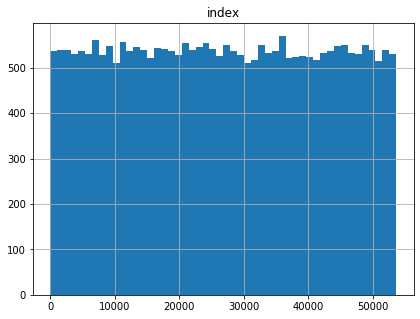

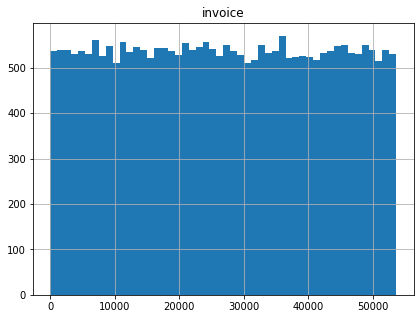

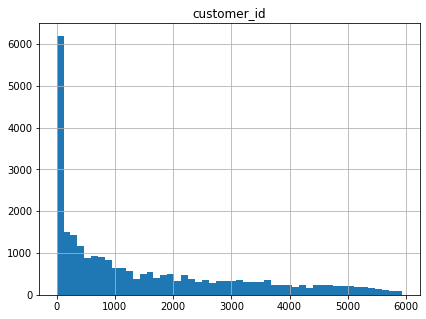

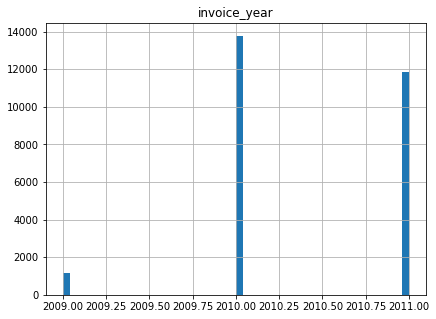

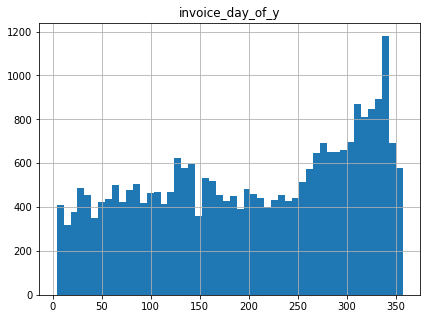

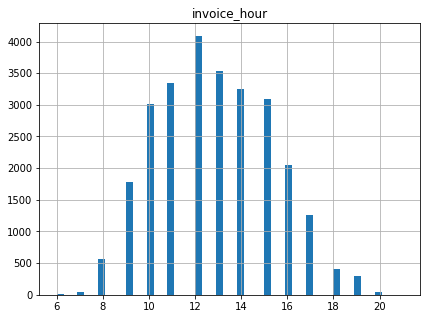

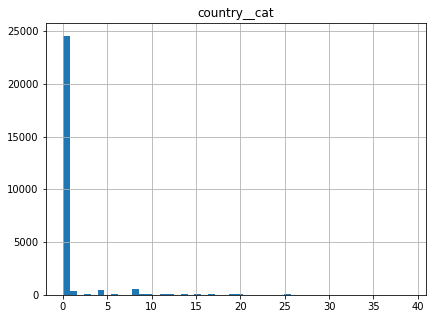

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


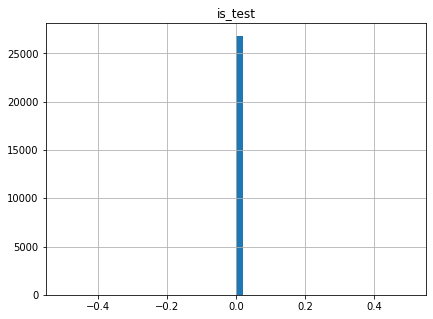

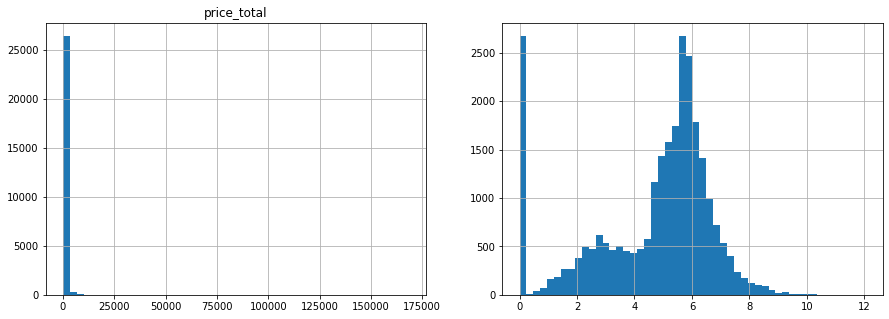

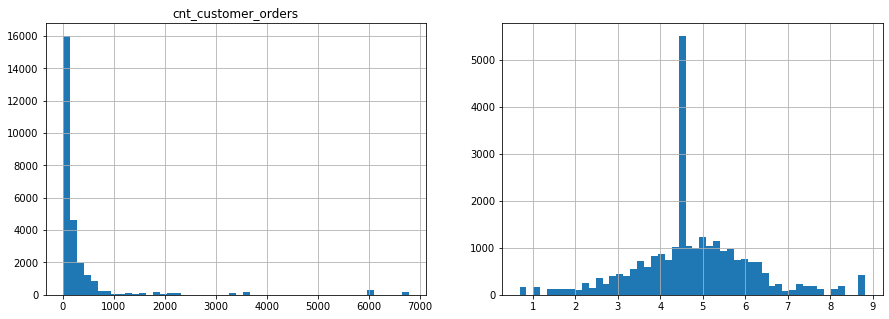

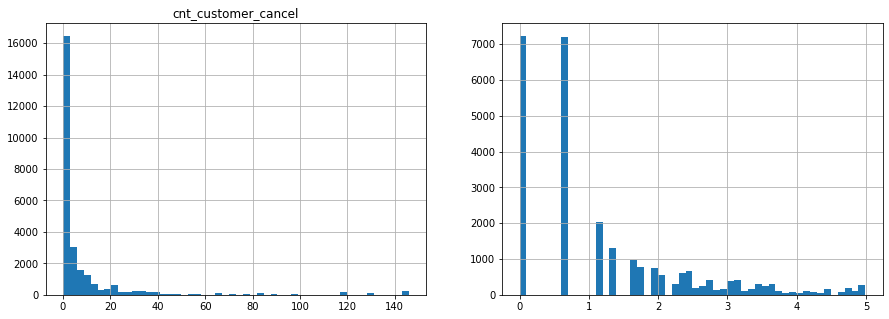

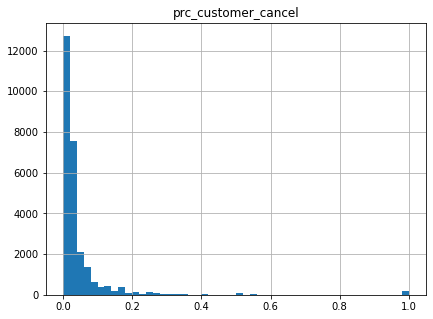

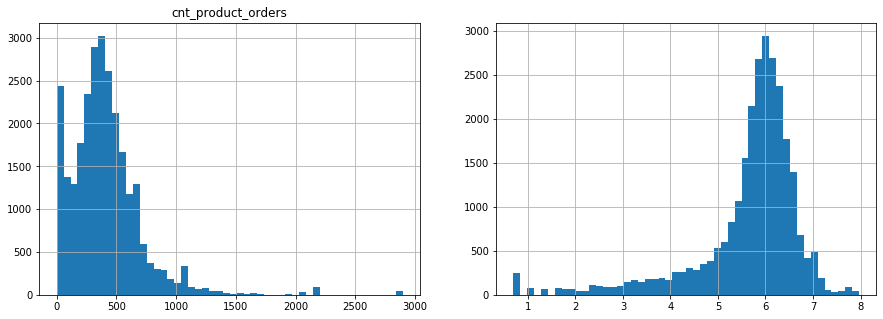

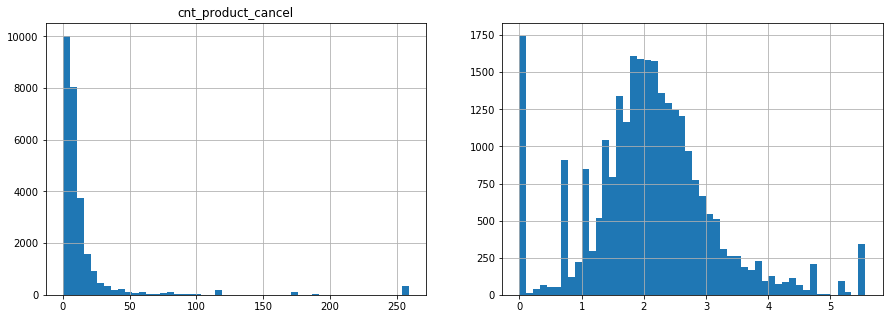

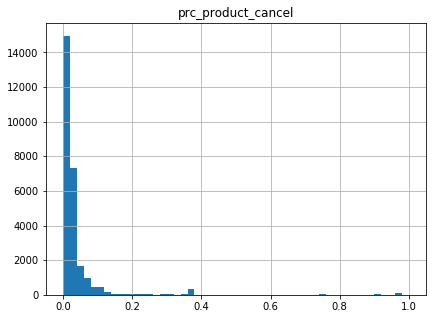

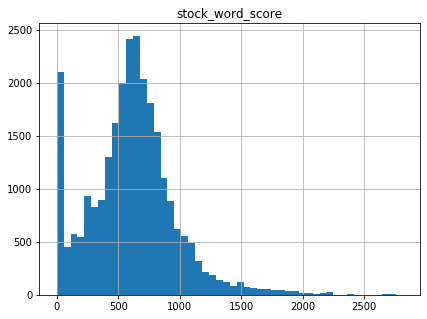

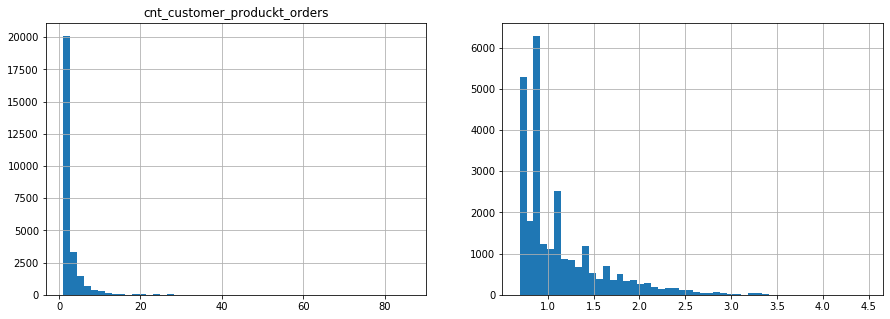

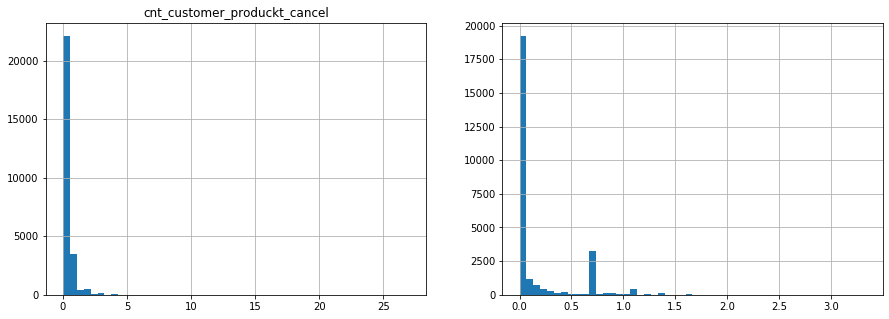

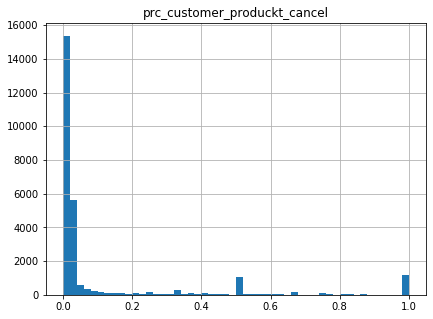

In [12]:
feats_to_log = ['cnt_customer_orders', 'cnt_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'price_total', 'cnt_customer_produckt_orders', 'cnt_customer_produckt_cancel']

for feat in train_group.columns:
    if 'log' in feat or feat == 'is_canceled': continue
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    train_group[feat].hist(bins=50)
    plt.title(feat)
    if feat in feats_to_log:
        plt.subplot(1,2,2)
        np.log1p(train_group[feat]).hist(bins=50)    
    plt.show()

In [13]:
use_log_feats = False

if use_log_feats:
    for feat in feats_to_log:
        train_group[feat + '_log'] = np.log1p(train_group[feat])
        if feat != 'total_return':
            test_group[feat + '_log'] = np.log1p(test_group[feat])

Double check if feats list containes the right features.

In [14]:
X, y, feats = get_feats_X_y(train_group)
feats

['index',
 'invoice',
 'customer_id',
 'invoice_year',
 'invoice_day_of_y',
 'invoice_hour',
 'country__cat',
 'price_total',
 'cnt_customer_orders',
 'cnt_customer_cancel',
 'prc_customer_cancel',
 'cnt_product_orders',
 'cnt_product_cancel',
 'prc_product_cancel',
 'stock_word_score',
 'cnt_customer_produckt_orders',
 'cnt_customer_produckt_cancel',
 'prc_customer_produckt_cancel']

At first glance it looks like the model is doing well when classification is concerned. However, in this challenge mean square error of the total value returned is the decisive score.

In [15]:
xgb_params = {
    'max_depth' : 2,
    'n_estimators' : 100,
    'learning_rate': 0.1,
    'seed': 0,    
}
model = XGBClassifier(**xgb_params)
test_model(model)

scores: [0.94801004 0.94147399 0.94823868]
mean: 0.9459075683635353, std: 0.0031364036746842332 



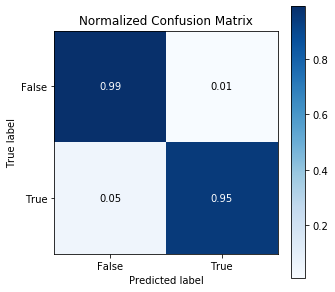

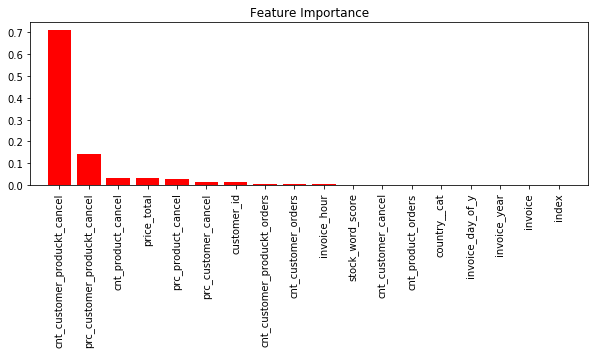

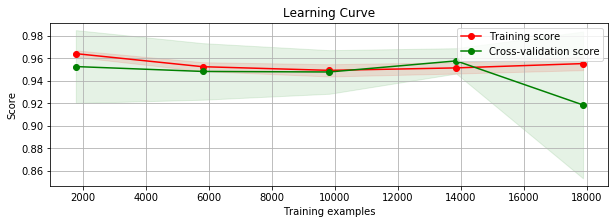

In [16]:
plot_model_char(model)

Total return per record was calculated and two basic models were created for score reference.

In [24]:
train_group['total_return'] = train_group['price_total'] * train_group['is_canceled']

y_pred = [0] * X.shape[0]
only_0_mse = mean_squared_error(y_pred, train_group['total_return'])

y_pred = [1] * X.shape[0]
only_1_mse = mean_squared_error(y_pred, train_group['total_return'])

print('mse you get when predicting only 0s: {}'.format(only_0_mse))
print('mse you get when predicting only 1s: {}'.format(only_1_mse))

mse you get when predicting only 0s: 1493771.4900318068
mse you get when predicting only 1s: 1493702.0167277197


When exported into kaggle the 0s prediction scored 10x better than 1s. It shows that the test set is skewed and it is beneficial to avoid false positives in this project. That is why function below was created. It calculates mse uses predict_proba and a classification threshold that can be changed to a value that allows less false positives.

In [27]:
def pred_proba_SKFold(df, xgb_params):
        X, y, feats = get_feats_X_y(df)
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        predict_proba = pd.Series([np.nan] * df.shape[0])
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            model = XGBClassifier(**xgb_params)
            model.fit(X[train_idx], y[train_idx])
            predict_proba[test_idx] = [x[1] for x in model.predict_proba(X[test_idx])]
        return predict_proba 

def score_mse_with_proba(treshold, xgb_params):

    treshold = treshold
    
    train_group['predict_proba'] = pred_proba_SKFold(train_group, xgb_params)
    
    if treshold is None:
        train_group['total_return_pred'] = train_group['price_total'] * train_group['predict_proba']
    else:
        train_group['is_canceled_pred'] = train_group['predict_proba'].map(lambda x: True if x > treshold else False)
        train_group['total_return_pred'] = train_group['price_total'] * train_group['is_canceled_pred']

    score = mean_squared_error(train_group['total_return'], train_group['total_return_pred'])
    

    # score by invoice
    train_group['mse'] = train_group[['total_return', 'total_return_pred']].apply(lambda x: mean_squared_error([x['total_return']], [x['total_return_pred']]), axis=1)
    
    return score

In [29]:
predict_proba(0.5, xgb_params)

2168237.2

In [28]:
predict_proba(0.7, xgb_params)

1145315.4

In [31]:
predict_proba(0.8, xgb_params)

1181535.5

After many experiments with diferent parameters it came out that the exported prediction scores better when it is a portion of total values, rather than all or nothing.

In [20]:
predict_proba(None, xgb_params)

935929.4106508306

As soon as this approach proved to be the most promising hyperparameter optimization was executed.

In [21]:
X, y, feats = get_feats_X_y(train)


def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'min_child_weight': int(space['min_child_weight']),
        'random_state': 0,
        'n_estimators': 100
    }

    score = predict_proba(None, xgb_params)

    print('Score: {}'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.2),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=20),
            max_evals=100,
            trials=trials)

print("The best params: ", best_params)

Score: 909127.3766708645                               
Score: 1971940.9995436333                                                       
Score: 1286007.9201111016                                                       
Score: 1115824.8358856572                                                       
Score: 1529585.5676759107                                                       
Score: 1257846.7551819268                                                       
Score: 1379779.370145735                                                        
Score: 1310837.5809039758                                                       
Score: 1746448.398679321                                                        
Score: 1653822.1901952717                                                       
Score: 1861983.2618781263                                                        
Score: 1671720.3917185206                                                        
Score: 906548.5004181922                           

In [22]:
xgb_params_opt = {
    'max_depth' : 3,
    'learning_rate': 0.0868882469376977,
    'n_estimators' : 100,
    'min_child_weight': 4.0,
    'seed': 0,    
}

model = XGBClassifier(**xgb_params_opt)
predict_proba(None, xgb_params_opt)

635076.636061055

The final training was executed using all data and optimized hyper parameters. The prediction was exported to kaagle and was good enough to secure me 4th place in the challenge leaderboard.
https://www.kaggle.com/c/online-retail/leaderboard

In [23]:
# final predict
X, y, feats = get_feats_X_y(train_group)

model = XGBClassifier(**xgb_params_opt)
model.fit(train_group[feats], train_group['is_canceled'])
test_group['is_canceled'] = [x[1] for x in model.predict_proba(test_group[feats])]
test_group['total_return'] = test_group['price_total'] * test_group['is_canceled']
test_group[ ['invoice', 'total_return'] ].to_csv('../../module3/output/submit.csv', index=False)